# Clustering Routine

This Jupyter Notebook can be ran after the initial crawling with the *crawl.py* python script to categorize a big number of news articles by their topics. The duration of the Jupyter Notebook processing time may vary depending on your dataset size. You can estimate at least a few hours for datasets bigger than 50 000 articles.

# Routine Of The Jupyter Notebook

This algorithm can be structured into the following main components:

1. Load crawled dataset from the folder *./crawl_json/*.
2. Preprocessing.
3. Visualize the data with wordclouds.
4. LDA Clustering.
5. Find the optimal amount of clusters with the coherence score.
6. Visualize the optimal topic clusters with LDAvis.
7. Subcluster all news articles by their release date.
8. Sort all documents into a folder hierarchy *./clustered_json/* to represent the cluster topics.


# Open Data From JSON
First we have to load our previously cralwed dataset into memory.

In [38]:
import pandas as pd
import numpy as np
import os
import glob

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
path = 'crawl_json/'
frames = []
for filename in glob.glob(os.path.join(path, '*.json')): #only process .JSON files in folder.      
    with open(filename, encoding='utf-8', mode='r') as currentFile:
        frames.append(pd.read_json(currentFile, orient='index'))

df = pd.concat(frames)
df.drop(['authors', 'image_url', 'localpath', 'title_page', 'title_rss'], axis = 1, inplace = True)
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date_download           date_modify          date_publish  \
0  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 11:09:15   
1  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 10:50:55   
2  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 12:45:16   

                                         description language  \
0  Neighbors » Forums » General Discussion » Arti...       en   
1  Brands and publishers seeking esports sponsors...       en   
2  For the latest updates to Global Public Square...       en   

                      source_domain  \
0          neighbors.denverpost.com   
1                  deloitte.wsj.com   
2  globalpublicsquare.blogs.cnn.com   

                                            maintext  \
0  Neighbors » Forums » General Discussion » Arti...   
1  Brands and publishers seeking esports sponsors...   
2  For the latest updates to Global Public Square...   

                                               title  \
0  Colorado poll: Majority favor allowing staff t...   
1   Esports on the Rise: Evaluating Brand ROI - C...   
2  Global Public Square has moved – Global Public...   

                                                 url  
0  http://neighbors.denverpost.com/viewtopic.php?...  
1  https://deloitte.wsj.com/cmo/2020/05/05/esport...  
2  https://globalpublicsquare.blogs.cnn.com/2015/...

# Amount of articles that will be processed:

In [40]:
amount_of_articles = len(df["maintext"])
print(f"Amount of articles: {amount_of_articles}")

Amount of articles: 77061


C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Preprocessing 

We will now continue with preparing the data for the actual clustering. Therefore we are lemmatizing all strings and removing all words that aren't nouns.

In [41]:
import re

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
df['id'] = df.index
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date_download           date_modify          date_publish  \
0  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 11:09:15   
1  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 10:50:55   
2  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 12:45:16   

                                         description language  \
0  Neighbors » Forums » General Discussion » Arti...       en   
1  Brands and publishers seeking esports sponsors...       en   
2  For the latest updates to Global Public Square...       en   

                      source_domain  \
0          neighbors.denverpost.com   
1                  deloitte.wsj.com   
2  globalpublicsquare.blogs.cnn.com   

                                            maintext  \
0  Neighbors » Forums » General Discussion » Arti...   
1  Brands and publishers seeking esports sponsors...   
2  For the latest updates to Global Public Square...   

                                               title  \
0  Colorado poll: Majority favor allowing staff t...   
1   Esports on the Rise: Evaluating Brand ROI - C...   
2  Global Public Square has moved – Global Public...   

                                                 url  id  
0  http://neighbors.denverpost.com/viewtopic.php?...   0  
1  https://deloitte.wsj.com/cmo/2020/05/05/esport...   1  
2  https://globalpublicsquare.blogs.cnn.com/2015/...   2

In [43]:
# Remove punctuation
df['maintext_prepro'] = \
df['maintext'].map(lambda x: re.sub('[,\.!?]', '', x))
# To lowercase
df['maintext_prepro'] = \
df['maintext_prepro'].map(lambda x: x.lower())

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:3: DeprecationWarning: invalid escape sequence \.
<>:3: DeprecationWarning: invalid escape sequence \.
<ipython-input-43-38c43510e950>:3: DeprecationWarning: invalid escape sequence \.
  df['maintext'].map(lambda x: re.sub('[,\.!?]', '', x))


In [44]:
import nltk
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [45]:
is_noun = lambda pos: pos[:2] == 'NN'
nouns = []

stemmer = WordNetLemmatizer()

estimated_minutes = amount_of_articles * 0.000217

print(f'Tokenizing all articles. This may take a while. (Estimate: ~{ round(estimated_minutes, 2) } minutes)')
df['tokenized_words'] = df['maintext'].apply(nltk.word_tokenize)
print("Finished tokenizing all articles. Continue with lemmatization & noun extraction.")


C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Tokenizing all articles. This may take a while. (Estimate: ~16.72 minutes)
Finished tokenizing all articles. Continue with lemmatization & noun extraction.


In [46]:
print("Lemmatization & noun extraction is running...")
for element in tqdm(df["tokenized_words"]):
	nouns.append(" ".join([stemmer.lemmatize(word) for (word, pos) in nltk.pos_tag(element) if is_noun(pos) and len(word) > 2]))    # joined as a single string per article

print("Finished lemmatization & noun extraction.")
df["maintext_nouns"] = nouns

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Lemmatization & noun extraction is running...


100%|██████████| 77061/77061 [1:49:11<00:00, 11.76it/s]

Finished lemmatization & noun extraction.


In [47]:
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date_download           date_modify          date_publish  \
0  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 11:09:15   
1  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 10:50:55   
2  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 12:45:16   

                                         description language  \
0  Neighbors » Forums » General Discussion » Arti...       en   
1  Brands and publishers seeking esports sponsors...       en   
2  For the latest updates to Global Public Square...       en   

                      source_domain  \
0          neighbors.denverpost.com   
1                  deloitte.wsj.com   
2  globalpublicsquare.blogs.cnn.com   

                                            maintext  \
0  Neighbors » Forums » General Discussion » Arti...   
1  Brands and publishers seeking esports sponsors...   
2  For the latest updates to Global Public Square...   

                                               title  \
0  Colorado poll: Majority favor allowing staff t...   
1   Esports on the Rise: Evaluating Brand ROI - C...   
2  Global Public Square has moved – Global Public...   

                                                 url  id  \
0  http://neighbors.denverpost.com/viewtopic.php?...   0   
1  https://deloitte.wsj.com/cmo/2020/05/05/esport...   1   
2  https://globalpublicsquare.blogs.cnn.com/2015/...   2   

                                     maintext_prepro  \
0  neighbors » forums » general discussion » arti...   
1  brands and publishers seeking esports sponsors...   
2  for the latest updates to global public square...   

                                     tokenized_words  \
0  [Neighbors, », Forums, », General, Discussion,...   
1  [Brands, and, publishers, seeking, esports, sp...   
2  [For, the, latest, updates, to, Global, Public...   

                                      maintext_nouns  
0  Neighbors Forums General Discussion Article Ta...  
1  Brands publisher esports sponsorship opportuni...  
2  update Global Public Square show information F...

# Word Cloud

The following word clouds will give you a general idea about how each step in preprocessing improves the quality of the dataset for our use case. The bigger a word is shown, the more frequent is its existence in our dataset. 

In [48]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1000, height=400, background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Word Cloud All Words

This word cloud includes all words of the articles without major filtering.

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


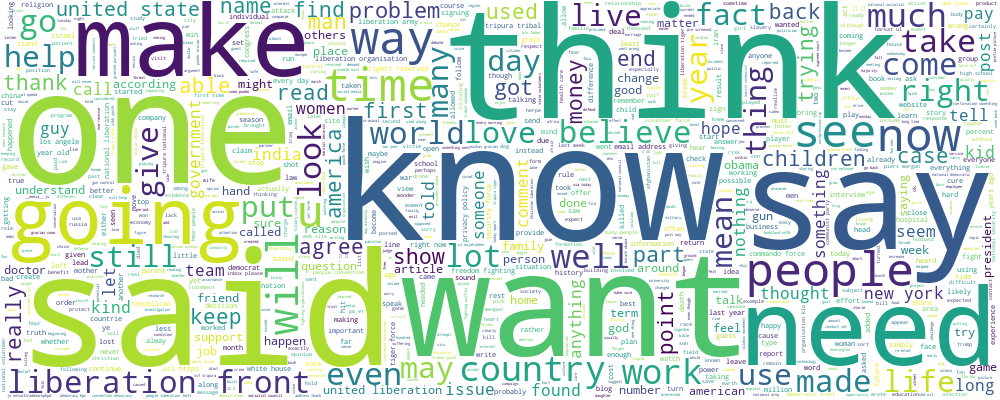

In [49]:
all_articles_string = ','.join(list(df['maintext_prepro'].values))
wordcloud.generate(all_articles_string)

wordcloud.to_image()

# Word Cloud Only Nouns

This word cloud shows you only the nouns of the acticles.

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


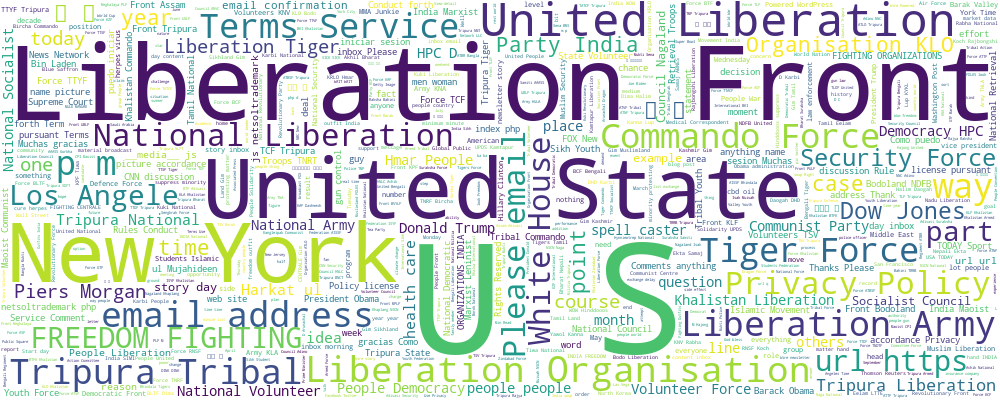

In [50]:
all_articles_nouns = ','.join(list(df['maintext_nouns'].values))
wordcloud.generate(all_articles_nouns)

wordcloud.to_image()

# Prepare data for LDA analysis

We will continue preparing our data for the LDA clustering by removing predefined stopwords (extended by *./stopwords.json*) and filtering out unwanted characters.

In [51]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import json
import regex

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
stop_words = stopwords.words('english')

with open("stopwords.json") as jsonFile:
    jsonStopwords = json.load(jsonFile)

#extend stopwords if desired
stop_words.extend(jsonStopwords)  


C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
#Tokenize Text
def sentence_to_words(sentences):
    for sent in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(sent, deacc=True))

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
#Remove Stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if (word not in stop_words)] for doc in texts]    #filtering

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
#Remove non alphanumeric words
def remove_non_alphanumeric(texts):
    return [[word for word in list if word.isalnum()] for list in texts]

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
def remove_non_ASCII(lists):
    for list in lists:
        for i, string in enumerate(list):
            if string.isascii():
                continue
            else:
                list.pop(i)
    return lists

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
maintext_data = df["maintext_nouns"].values.tolist()
df["maintext_ready"] = list(sentence_to_words(maintext_data))

maintext_ready = remove_stopwords(df["maintext_ready"].tolist())
maintext_ready = remove_non_ASCII(maintext_ready)
df["maintext_ready"]  = maintext_ready

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date_download           date_modify          date_publish  \
0  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 11:09:15   
1  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 10:50:55   
2  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 12:45:16   

                                         description language  \
0  Neighbors » Forums » General Discussion » Arti...       en   
1  Brands and publishers seeking esports sponsors...       en   
2  For the latest updates to Global Public Square...       en   

                      source_domain  \
0          neighbors.denverpost.com   
1                  deloitte.wsj.com   
2  globalpublicsquare.blogs.cnn.com   

                                            maintext  \
0  Neighbors » Forums » General Discussion » Arti...   
1  Brands and publishers seeking esports sponsors...   
2  For the latest updates to Global Public Square...   

                                               title  \
0  Colorado poll: Majority favor allowing staff t...   
1   Esports on the Rise: Evaluating Brand ROI - C...   
2  Global Public Square has moved – Global Public...   

                                                 url  id  \
0  http://neighbors.denverpost.com/viewtopic.php?...   0   
1  https://deloitte.wsj.com/cmo/2020/05/05/esport...   1   
2  https://globalpublicsquare.blogs.cnn.com/2015/...   2   

                                     maintext_prepro  \
0  neighbors » forums » general discussion » arti...   
1  brands and publishers seeking esports sponsors...   
2  for the latest updates to global public square...   

                                     tokenized_words  \
0  [Neighbors, », Forums, », General, Discussion,...   
1  [Brands, and, publishers, seeking, esports, sp...   
2  [For, the, latest, updates, to, Global, Public...   

                                      maintext_nouns  \
0  Neighbors Forums General Discussion Article Ta...   
1  Brands publisher esports sponsorship opportuni...   
2  update Global Public Square show information F...   

                                      maintext_ready  
0  [neighbors, forums, general, discussion, talk,...  
1  [brands, publisher, esports, sponsorship, oppo...  
2  [update, global, public, square, show, fareed,...

# Wordcloud of the ready-to-cluster articles

This is the word cloud of the dataset which we will actually apply out LDA clustering on.

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


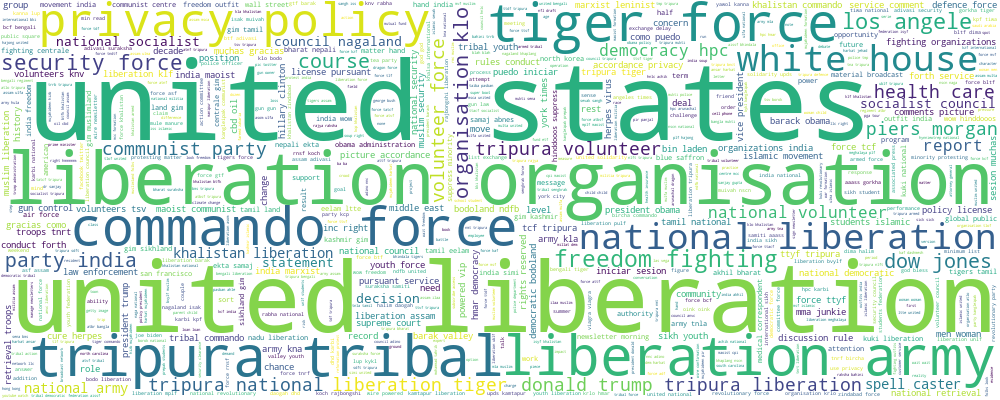

In [59]:
ready_wordlist = []
for element in df["maintext_ready"]:
    ready_wordlist.append(','.join(list(element)))

all_articles_ready = ','.join(ready_wordlist)
wordcloud.generate(all_articles_ready)

wordcloud.to_image()

# Create the Corpus

Creating a corpus is needed to have data that is understandable to gensim. This will be given to the LDA algorithm to perform the clustering.

In [60]:
import gensim.corpora as corpora

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
data = df["maintext_ready"].tolist()

word_dictionary = corpora.Dictionary(data)

corpus = [word_dictionary.doc2bow(text) for text in data]   #create the corpus

df["corpus"] = corpus

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date_download           date_modify          date_publish  \
0  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 11:09:15   
1  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 10:50:55   
2  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 12:45:16   

                                         description language  \
0  Neighbors » Forums » General Discussion » Arti...       en   
1  Brands and publishers seeking esports sponsors...       en   
2  For the latest updates to Global Public Square...       en   

                      source_domain  \
0          neighbors.denverpost.com   
1                  deloitte.wsj.com   
2  globalpublicsquare.blogs.cnn.com   

                                            maintext  \
0  Neighbors » Forums » General Discussion » Arti...   
1  Brands and publishers seeking esports sponsors...   
2  For the latest updates to Global Public Square...   

                                               title  \
0  Colorado poll: Majority favor allowing staff t...   
1   Esports on the Rise: Evaluating Brand ROI - C...   
2  Global Public Square has moved – Global Public...   

                                                 url  id  \
0  http://neighbors.denverpost.com/viewtopic.php?...   0   
1  https://deloitte.wsj.com/cmo/2020/05/05/esport...   1   
2  https://globalpublicsquare.blogs.cnn.com/2015/...   2   

                                     maintext_prepro  \
0  neighbors » forums » general discussion » arti...   
1  brands and publishers seeking esports sponsors...   
2  for the latest updates to global public square...   

                                     tokenized_words  \
0  [Neighbors, », Forums, », General, Discussion,...   
1  [Brands, and, publishers, seeking, esports, sp...   
2  [For, the, latest, updates, to, Global, Public...   

                                      maintext_nouns  \
0  Neighbors Forums General Discussion Article Ta...   
1  Brands publisher esports sponsorship opportuni...   
2  update Global Public Square show information F...   

                                      maintext_ready  \
0  [neighbors, forums, general, discussion, talk,...   
1  [brands, publisher, esports, sponsorship, oppo...   
2  [update, global, public, square, show, fareed,...   

                                              corpus  
0  [(0, 2), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2...  
1  [(24, 1), (25, 1), (26, 1), (27, 7), (28, 1), ...  
2  [(3, 1), (24, 5), (54, 1), (82, 1), (95, 1), (...

# Build a LDA model & calculate Coherence Score

The following code is going through a prefined range of topic amounts to check which clustering approach suits the dataset best. Each iteration inlcludes the clustering of all articles and the calculation of the coherence score. A sudden drop in the coherence score will trigger an Elbow Method. The algorithm will continue with taking the best possible clusters from there on.

In [63]:
from pprint import pprint   #pretty printing
from gensim.models import CoherenceModel

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
topic_amount_start = 10     #specify where to start generating clusters
topic_amount_end = 200      #specify the maximum amount of clusters
iteration_interval = 5    

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
amount_of_topics = 0
best_coherence = 0

coherences = []
lda_models = []

print(f"Calculating the optimal amount of clusters inbetween {topic_amount_start} and {topic_amount_end}.")

#Find the best possible coherence value inbetween the given min and max amount of articles. Continue with the best lda model found.
for amount_of_topics in range(topic_amount_start, topic_amount_end, iteration_interval):   
    lda_model = gensim.models.LdaMulticore(corpus = corpus, id2word = word_dictionary, num_topics = amount_of_topics, alpha=0.1, eta=0.01)   #build the LDA model

    cm = CoherenceModel(model=lda_model, texts=df["maintext_ready"].tolist(), dictionary=word_dictionary, coherence='c_v')     #calculate coherence
    coherence = cm.get_coherence()
    print(f"Coherence with {amount_of_topics} topics: ", coherence)

    coherences.append(coherence)
    lda_models.append(lda_model)


C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Calculating the optimal amount of clusters inbetween 10 and 200.


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# A graph about how the coherence changes depending on the amount of clusters
plt.plot(range(topic_amount_start, topic_amount_end), coherences, 'bx-')
plt.xlabel('Amount of Clusters/Topics')
plt.ylabel('Coherence Score')
plt.title('The Coherence Score for every cluster amount')
plt.show()

In [ ]:
from kneed import KneeLocator
print("The elbow point of the curve is: ")
kneedle = KneeLocator(range(topic_amount_start, topic_amount_end), coherences, S=1.0, curve="convex", direction="decreasing")
print(kneedle.knee_y)
knee = kneedle.knee

# Displaying the LDA model

This is the built LDA model. The first number represents the cluster ID. The other part shows you the propablity of words in the specific topic.

In [ ]:
pprint(best_lda_model.print_topics())
articles_lda = best_lda_model[corpus]

[(57,
  '0.008*"gun" + 0.006*"force" + 0.005*"woman" + 0.004*"liberation" + '
  '0.004*"school" + 0.004*"national" + 0.004*"law" + 0.003*"kid" + 0.003*"man" '
  '+ 0.003*"child"'),
 (34,
  '0.008*"iniciar" + 0.007*"como" + 0.007*"puedo" + 0.007*"gracias" + '
  '0.007*"sesion" + 0.007*"muchas" + 0.006*"president" + 0.004*"war" + '
  '0.004*"obama" + 0.004*"laden"'),
 (64,
  '0.019*"force" + 0.015*"liberation" + 0.014*"tripura" + 0.012*"national" + '
  '0.006*"army" + 0.006*"india" + 0.006*"united" + 0.004*"tribal" + '
  '0.004*"tiger" + 0.003*"kuki"'),
 (0,
  '0.006*"gun" + 0.005*"right" + 0.005*"cialis" + 0.005*"viagra" + '
  '0.004*"child" + 0.004*"school" + 0.003*"modi" + 0.003*"government" + '
  '0.003*"market" + 0.003*"llc"'),
 (37,
  '0.017*"tripura" + 0.016*"force" + 0.012*"liberation" + 0.010*"national" + '
  '0.006*"united" + 0.005*"india" + 0.005*"doctor" + 0.004*"army" + '
  '0.004*"tribal" + 0.004*"khalistan"'),
 (33,
  '0.009*"loan" + 0.005*"force" + 0.004*"business" + 0.00

# Visualize the LDA model

This visualization is interactable and helps you identifying the quality of the LDA clustering by hand.

In [ ]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
from IPython.display import HTML, display

pyLDAvis.enable_notebook()

In [ ]:
LDAvis_data_filepath = os.path.join('./lda_results/ldavis_data_'+str(amount_of_topics)+'topics')

LDAvis_prepared = pyLDAvis.gensim_models.prepare(best_lda_model, corpus, word_dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

#load pre-prepared pyLDAvis data
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_data = pickle.load(f)
pyLDAvis.save_html(LDAvis_data, './lda_results/ldavis_data_'+ str(amount_of_topics) +'topics.html')
LDAvis_data #show the data

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2      0.278900 -0.002336       1        1  7.880801
55    -0.020266  0.036053       2        1  7.093742
5     -0.019933 -0.012397       3        1  4.958567
45    -0.009104 -0.037620       4        1  4.349791
10    -0.046989 -0.057433       5        1  4.174220
...         ...       ...     ...      ...       ...
64     0.089570 -0.000291      61        1  0.082123
26     0.049647 -0.005159      62        1  0.074416
1      0.078362 -0.016783      63        1  0.059325
51     0.072501 -0.015288      64        1  0.056374
41     0.071899 -0.000902      65        1  0.053917

[65 rows x 5 columns], topic_info=             Term           Freq          Total Category  logprob  loglift
1275        force  171850.000000  171850.000000  Default  30.0000  30.0000
823    liberation  142120.000000  142120.000000  Default  29.0000  29.0000
36563     tripura  119229.000000  119229.000000  Default  28.0000  28.0000
871      national  119778.000000  119778.000000  Default  27.0000  27.0000
281         india   95419.000000   95419.000000  Default  26.0000  26.0000
...           ...            ...            ...      ...      ...      ...
1607     security      39.989577   58685.110664  Topic65  -6.1365   0.2341
152         right      40.133897   86745.118335  Topic65  -6.1329  -0.1530
267           gun      37.979584   90557.571362  Topic65  -6.1881  -0.2512
265           god      35.771834   66284.968033  Topic65  -6.2480   0.0009
305           man      35.344428   79048.568010  Topic65  -6.2600  -0.1872

[5925 rows x 6 columns], token_table=        Topic      Freq     Term
term                            
88541       1  0.011281      aaf
88541       2  0.022562      aaf
88541       4  0.011281      aaf
88541       5  0.011281      aaf
88541       6  0.789674      aaf
...       ...       ...      ...
44107      40  0.006482      ไหล
44107      45  0.003241      ไหล
164518      1  0.127232  一見の価値あり
164518     24  0.572545  一見の価値あり
164518     25  0.127232  一見の価値あり

[82407 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 56, 6, 46, 11, 36, 23, 14, 30, 22, 59, 24, 25, 43, 40, 15, 41, 62, 51, 45, 54, 29, 20, 55, 12, 19, 7, 53, 57, 26, 31, 16, 9, 61, 37, 8, 13, 50, 44, 21, 1, 64, 17, 47, 5, 63, 35, 48, 33, 49, 58, 39, 34, 32, 28, 60, 18, 4, 38, 10, 65, 27, 2, 52, 42])

# Store Cluster IDs to dataframe

To be able to correctly sort all articles into a floder hierachy wee need to store each articles cluster id into the dataframe.

In [ ]:
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric

topics = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]

lda_topics = best_lda_model.show_topics(num_words=5)
for topic in lda_topics:
    print(topic)
    topics.append(preprocess_string(topic[1], filters))

(20, '0.005*"woman" + 0.004*"police" + 0.003*"money" + 0.003*"game" + 0.003*"law"')
(38, '0.004*"war" + 0.004*"force" + 0.004*"money" + 0.004*"child" + 0.004*"national"')
(47, '0.008*"india" + 0.006*"modi" + 0.005*"woman" + 0.004*"child" + 0.004*"man"')
(60, '0.005*"god" + 0.005*"slavery" + 0.005*"liberation" + 0.004*"force" + 0.004*"tripura"')
(37, '0.017*"tripura" + 0.016*"force" + 0.012*"liberation" + 0.010*"national" + 0.006*"united"')
(0, '0.006*"gun" + 0.005*"right" + 0.005*"cialis" + 0.005*"viagra" + 0.004*"child"')
(64, '0.019*"force" + 0.015*"liberation" + 0.014*"tripura" + 0.012*"national" + 0.006*"army"')
(29, '0.012*"herpes" + 0.006*"cure" + 0.006*"doctor" + 0.006*"disease" + 0.005*"work"')
(54, '0.004*"police" + 0.003*"force" + 0.003*"government" + 0.003*"law" + 0.003*"president"')
(8, '0.011*"ufc" + 0.008*"fight" + 0.006*"mma" + 0.005*"iran" + 0.005*"war"')


C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topic_list = []
topic_percentage_list = []
topic_keywords_list = []

for row in tqdm(articles_lda):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    topic_num = row[0][0]
    prop_topic = row[0][1]

    wp = best_lda_model.show_topic(topic_num)
    topic_keywords = ", ".join([word for word, prop in wp])
    topic_list.append(int(topic_num))
    topic_percentage_list.append(round(prop_topic,5))
    topic_keywords_list.append(topic_keywords)


df["LDA_ID"] = topic_list    ##the id of the topic
df["LDA_topic_percentage"] = topic_percentage_list  #how well the topic fits to this specifc article
df["LDA_topic_keywords"] = topic_keywords_list  #the dominant keywords for the topic

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


77061


100%|██████████| 77061/77061 [2:09:08<00:00,  9.95it/s]


In [ ]:
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date_download           date_modify          date_publish  \
0  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 11:09:15   
1  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 10:50:55   
2  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 12:45:16   

                                         description language  \
0  Neighbors » Forums » General Discussion » Arti...       en   
1  Brands and publishers seeking esports sponsors...       en   
2  For the latest updates to Global Public Square...       en   

                      source_domain  \
0          neighbors.denverpost.com   
1                  deloitte.wsj.com   
2  globalpublicsquare.blogs.cnn.com   

                                            maintext  \
0  Neighbors » Forums » General Discussion » Arti...   
1  Brands and publishers seeking esports sponsors...   
2  For the latest updates to Global Public Square...   

                                               title  \
0  Colorado poll: Majority favor allowing staff t...   
1   Esports on the Rise: Evaluating Brand ROI - C...   
2  Global Public Square has moved – Global Public...   

                                                 url  id  \
0  http://neighbors.denverpost.com/viewtopic.php?...   0   
1  https://deloitte.wsj.com/cmo/2020/05/05/esport...   1   
2  https://globalpublicsquare.blogs.cnn.com/2015/...   2   

                                     maintext_prepro  \
0  neighbors » forums » general discussion » arti...   
1  brands and publishers seeking esports sponsors...   
2  for the latest updates to global public square...   

                                     tokenized_words  \
0  [Neighbors, », Forums, », General, Discussion,...   
1  [Brands, and, publishers, seeking, esports, sp...   
2  [For, the, latest, updates, to, Global, Public...   

                                      maintext_nouns  \
0  Neighbors Forums General Discussion Article Ta...   
1  Brands publisher esports sponsorship opportuni...   
2  update Global Public Square show information F...   

                                      maintext_ready  \
0  [neighbors, forums, general, discussion, talk,...   
1  [brands, publisher, esports, sponsorship, oppo...   
2  [update, global, public, square, show, fareed,...   

                                              corpus  LDA_ID  \
0  [(0, 2), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2...       6   
1  [(24, 1), (25, 1), (26, 1), (27, 7), (28, 1), ...      12   
2  [(3, 1), (24, 5), (54, 1), (82, 1), (95, 1), (...      15   

   LDA_topic_percentage                                 LDA_topic_keywords  
0               0.57682  force, cbd, national, child, oil, liberation, ...  
1               0.45695  gun, piers, car, team, force, tour, obama, rig...  
2               0.84557  god, gun, pigs, church, obama, die, perish, ha...

# Output LDA clustering to json files


In [ ]:
df = df.drop(columns=["maintext_prepro", "tokenized_articles", "maintext_nouns", "corpus", "id"], errors='ignore')   #drop unwanted attributes that should not be output into the json files.

filtered_maintext = [ " ".join(row["maintext_ready"]) for index, row in df.iterrows() ]   

df["filtered_maintext"] = filtered_maintext

df = df.drop(columns=["maintext_ready", "tokenized_words"])

df.head()

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date_download           date_modify          date_publish  \
0  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 11:09:15   
1  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 10:50:55   
2  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 12:45:16   
3  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 11:08:18   
4  07/14/2021, 01:00:35  07/14/2021, 01:00:35  06/12/2021, 11:09:30   

                                         description language  \
0  Neighbors » Forums » General Discussion » Arti...       en   
1  Brands and publishers seeking esports sponsors...       en   
2  For the latest updates to Global Public Square...       en   
3  Skip to main content Published: Jan 23, 2019 B...       en   
4  One of artist Shepard Fairey's next projects c...       en   

                      source_domain  \
0          neighbors.denverpost.com   
1                  deloitte.wsj.com   
2  globalpublicsquare.blogs.cnn.com   
3           jobs.washingtonpost.com   
4          latimesblogs.latimes.com   

                                            maintext  \
0  Neighbors » Forums » General Discussion » Arti...   
1  Brands and publishers seeking esports sponsors...   
2  For the latest updates to Global Public Square...   
3  Skip to main content Published: Jan 23, 2019By...   
4   One of artist Shepard Fairey's next projects ...   

                                               title  \
0  Colorado poll: Majority favor allowing staff t...   
1   Esports on the Rise: Evaluating Brand ROI - C...   
2  Global Public Square has moved – Global Public...   
3           How Much Salary Negotiation Is Too Much?   
4  Shepard Fairey puts services up for auction | ...   

                                                 url  LDA_ID  \
0  http://neighbors.denverpost.com/viewtopic.php?...       6   
1  https://deloitte.wsj.com/cmo/2020/05/05/esport...      12   
2  https://globalpublicsquare.blogs.cnn.com/2015/...      15   
3  https://jobs.washingtonpost.com/article/how-mu...      13   
4  https://latimesblogs.latimes.com/culturemonste...      18   

   LDA_topic_percentage                                 LDA_topic_keywords  \
0               0.57682  force, cbd, national, child, oil, liberation, ...   
1               0.45695  gun, piers, car, team, force, tour, obama, rig...   
2               0.84557  god, gun, pigs, church, obama, die, perish, ha...   
3               0.58582  school, child, student, money, city, teacher, ...   
4               0.55750  child, god, india, president, player, right, w...   

                                   filtered_maintext  
0  neighbors forums general discussion talk denve...  
1  brands publisher esports sponsorship opportuni...  
2  update global public square show fareed take g...  
3  skip arden davidson salary balancing act price...  
4  artist shepard fairey project portrait los ang...

# Generating folder structure

The following code creates the desired folder hierarchy and names each cluster after the top 3 dominant words in each one. Within each cluster/folder we are subclustering all articles by their release date.
The output json file has the format *year-month.json*. 

In [ ]:
import ujson

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df.reset_index(drop=True,inplace=True)

for cluster_id, data in df.groupby(df.LDA_ID):
    item = data.LDA_topic_keywords.iloc[0].split(",")
    with open(f'./lda_clustered_json/cluster_{cluster_id}-{item[0]}_{item[1]}_{item[2]}.json', 'w', encoding='utf-8') as f:
        f.write(ujson.dumps(data.to_dict('index'), indent=4, ensure_ascii=False, escape_forward_slashes=False))

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
